# Entrainement de modèles de prédiction SPOT 

In [381]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from pathlib import Path
import numpy as np
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso   
try:   
    from xgboost import XGBRegressor   
    HAS_XGB = True
except ImportError:   
    HAS_XGB = False   
    print("XGBoost non installé, le modèle XGBRegressor sera ignoré.")

import pickle
import joblib
import json


In [382]:
SPOT_PATH = 'data/France.csv'
ECO2MIX_PATH = "data/eCO2mix_RTE_En-cours-Consolide.csv"
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TARGET = "Price (EUR/MWhe)"

FEATURE_LIST = [
       'Consommation',
       'Prévision J-1', 
       'Prévision J', 
       'Fioul', 
       'Charbon', 
       'Gaz', 
       'Nucléaire',
       'Eolien', 
       'Solaire', 
       'Hydraulique', 
       'Pompage', 
       'Bioénergies',
       'Ech. physiques', 
       'Taux de Co2', 
       'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 
       'Ech. comm. Italie', 
       'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 
       'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 
       'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 
       'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 
       'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', 
       ' Stockage batterie', 
       'Déstockage batterie',
       'Eolien terrestre', 
       'Eolien offshore']




### lecture

In [383]:
df_spot = pd.read_csv(SPOT_PATH)
df_spot["Datetime (Local)"] = pd.to_datetime(df_spot["Datetime (Local)"])
df_spot["Datetime (UTC)"] = pd.to_datetime(df_spot["Datetime (UTC)"])


df_eco2mix = pd.read_csv(ECO2MIX_PATH, sep='\t', encoding='latin-1', index_col=False)
df_eco2mix['Datetime'] = pd.to_datetime(df_eco2mix['Date'] + ' ' + df_eco2mix['Heures'])
df_eco2mix['Datetime'] = pd.to_datetime(df_eco2mix['Datetime'], format='%Y-%m-%d %H:%M:%S')
df_eco2mix = df_eco2mix.dropna()


df_spot : aucune donnée manquante sur la période de 2015-01-01 à 25-10-30, granularité : heure

df_eco2mix : Certaines données manquantes car granularité de 30min au lieu de toutes les 15 min 

On cherche à prédir SPOT chaque heure => dropna OK car granularité plus faible 

après dropna = granularité 30 min de 2024-01-01 à 2024-12-31

In [384]:
# # Analyse temporelle des prix spot de l'électricité
# import matplotlib.pyplot as plt

# # Ajouter des colonnes pour l'analyse temporelle
# df_spot['Day_of_Week'] = df_spot['Datetime (Local)'].dt.day_name()
# df_spot['Month'] = df_spot['Datetime (Local)'].dt.month_name()

# # Calculer les moyennes par heures de la journée
# hourly_avg = df_spot.groupby(df_spot['Datetime (Local)'].dt.hour)['Price (EUR/MWhe)'].mean()

# # Calculer les moyennes par jour de la semaine
# weekly_avg = df_spot.groupby('Day_of_Week')['Price (EUR/MWhe)'].mean()

# # Calculer les moyennes par mois
# monthly_avg = df_spot.groupby('Month')['Price (EUR/MWhe)'].mean()


# # Visualiser les tendances
# plt.figure(figsize=(16, 8))


# # Moyennes par heures de la journée
# plt.subplot(1, 3, 1)
# hourly_avg.plot(kind='bar', color='lightgreen')
# plt.title('Prix moyen par heure de la journée')
# plt.ylabel('Prix moyen (EUR/MWhe)')
# plt.xlabel('Heure de la journée')

# # Moyennes par jour de la semaine
# plt.subplot(1, 3, 2)
# weekly_avg = weekly_avg.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# weekly_avg.plot(kind='bar', color='skyblue')
# plt.title('Prix moyen par jour de la semaine')
# plt.ylabel('Prix moyen (EUR/MWhe)')
# plt.xlabel('Jour de la semaine')

# # Moyennes par mois
# plt.subplot(1, 3, 3)
# monthly_avg = monthly_avg.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# monthly_avg.plot(kind='bar', color='orange')
# plt.title('Prix moyen par mois')
# plt.ylabel('Prix moyen (EUR/MWhe)')
# plt.xlabel('Mois')

# plt.tight_layout()
# plt.show()

## Préparation du dataframe pour entrainement 

In [385]:
def prepare_data(df_spot, df_eco2mix, target, feature_list):
    """
    Prépare les données pour l'entraînement en fusionnant et en filtrant les colonnes nécessaires.

    Args:
        df_spot (pd.DataFrame): Données SPOT contenant les prix.
        df_eco2mix (pd.DataFrame): Données eCO2mix contenant les caractéristiques.
        target (str): Nom de la colonne cible.
        feature_list (list): Liste des colonnes de caractéristiques.

    Returns:
        pd.DataFrame: DataFrame filtré prêt pour l'entraînement.
    """
    # Récupération de l'heure
    df_spot['Date_heure'] = df_spot['Datetime (Local)'].dt.floor('h')
    df_eco2mix['Date_heure'] = df_eco2mix['Datetime'].dt.floor('h')

    # Agréger eCO2mix à l’heure (somme des valeurs numériques)
    num_cols = [c for c in df_eco2mix.columns if c not in ['Datetime', 'heure'] and is_numeric_dtype(df_eco2mix[c])]
    df_eco2mix_hour = df_eco2mix.groupby('Date_heure', as_index=False)[num_cols].mean()

    # Fusion des deux DataFrames
    df_model = pd.merge(df_spot, df_eco2mix_hour, on='Date_heure', how='inner')
    df_model.sort_values('Date_heure', inplace=True)

    # Filtrer les colonnes nécessaires
    df_filtered = df_model[['Date_heure', target] + feature_list]

    return df_filtered

df= prepare_data(df_spot, df_eco2mix, TARGET, FEATURE_LIST)


Dataframe = 8784 entrées sur toute l'année 2024 granularité 1h - aggregation eco2mix somme des valeurs à la demi heure 

In [386]:

# --- Vérification des features
missing = [c for c in FEATURE_LIST if c not in df.columns]
if missing:
    raise ValueError(f"Colonnes features manquantes dans le merge final: {missing}")

# Suppression éventuelle de lignes sans cible
df = df.dropna(subset=[TARGET]).copy()

X_all = df[FEATURE_LIST].copy()
y_all = df[TARGET].astype(float).copy()

print("Dimensions X, y:", X_all.shape, y_all.shape)


Dimensions X, y: (8784, 36) (8784,)


In [387]:
# --- Prétraitement : Imputation médiane + StandardScaler sur les colonnes numériques
def make_prepro():
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    return ColumnTransformer([('num', num_pipe, FEATURE_LIST)], remainder='drop')

prepro = make_prepro()

In [388]:
def evaluate(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    med  = median_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MedAE": med, "R2": r2}


In [389]:

def backtest_model(model, X, y, n_splits=5):
    """
    Validation croisée temporelle : à chaque fold, on fit sur le passé et on évalue sur un bloc futur.
    Retourne un DataFrame de métriques par fold.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rows = []
    for i, (tr, te) in enumerate(tscv.split(X), start=1):
        pipe = Pipeline([("prepro", make_prepro()), ("model", model)])
        pipe.fit(X.iloc[tr], y.iloc[tr])
        pred = pipe.predict(X.iloc[te])
        m = evaluate(y.iloc[te], pred)
        m["fold"] = i
        rows.append(m)
        print(f"Fold {i}: {m}")
    return pd.DataFrame(rows)


In [396]:

# --- Définition des modèles (Linear, Ridge, Lasso, RF, XGB si dispo) ---
models_to_eval = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=5e-4, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
}
if HAS_XGB:
    models_to_eval["XGBRegressor"] = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist"
    )


In [397]:

# --- Backtests (CV temporelle) ---
cv_results = []
for name, mdl in models_to_eval.items():
    print(f"\n=== Backtest {name} ===")
    m = backtest_model(mdl, X_all, y_all, n_splits=5)
    m["model"] = name
    cv_results.append(m)

cv_results_df = pd.concat(cv_results, ignore_index=True)
display(cv_results_df)

# # Résumé par modèle (moyenne des folds)
summary = (
    cv_results_df
    .groupby("model", as_index=False)[["MAE", "RMSE", "MedAE", "R2"]]
    .mean()
    .sort_values("MAE")
)
# display(summary)

# # --- Visualisation des .... moyens ---
# plt.figure()
# plt.bar(summary["model"], summary["MAE"])
# plt.ylabel("MAE (moyenne CV)")
# plt.title("Comparaison des modèles — TimeSeriesSplit")
# plt.xticks(rotation=20)
# plt.grid(True, axis="y")
# plt.show()


=== Backtest LinearRegression ===
Fold 1: {'MAE': 68.0000220920233, 'RMSE': 8220.362136407804, 'MedAE': 80.2487998575479, 'R2': -6.69634139275958, 'fold': 1}
Fold 2: {'MAE': 16.229085417888957, 'RMSE': 497.73216108529164, 'MedAE': 12.109482363224519, 'R2': 0.5006808477347591, 'fold': 2}
Fold 3: {'MAE': 19.952506269372428, 'RMSE': 674.7848270285627, 'MedAE': 15.29890600259656, 'R2': 0.5237431865985347, 'fold': 3}
Fold 4: {'MAE': 16.566226597786834, 'RMSE': 434.06061450094967, 'MedAE': 13.691829539280342, 'R2': 0.6792234530474994, 'fold': 4}
Fold 5: {'MAE': 29.048256357613425, 'RMSE': 1235.1274239624927, 'MedAE': 27.84084426208439, 'R2': 0.2529613388930043, 'fold': 5}

=== Backtest Ridge ===
Fold 1: {'MAE': 70.52873919647391, 'RMSE': 8753.515045716898, 'MedAE': 83.69443989143531, 'R2': -7.19550757747208, 'fold': 1}
Fold 2: {'MAE': 16.401960090807094, 'RMSE': 507.1066849024877, 'MedAE': 12.25927292305471, 'R2': 0.4912764337722656, 'fold': 2}
Fold 3: {'MAE': 19.229470328661396, 'RMSE': 61

,MAE,RMSE,MedAE,R2,fold,model
0,68.000022,8220.362136,80.248800,-6.696341,1,LinearRegression
1,16.229085,497.732161,12.109482,0.500681,2,LinearRegression
2,19.952506,674.784827,15.298906,0.523743,3,LinearRegression
3,16.566227,434.060615,13.691830,0.679223,4,LinearRegression
4,29.048256,1235.127424,27.840844,0.252961,5,LinearRegression
5,70.528739,8753.515046,83.694440,-7.195508,1,Ridge
6,16.401960,507.106685,12.259273,0.491276,2,Ridge
7,19.229470,616.360810,14.966163,0.564978,3,Ridge
8,16.375800,418.788110,13.736336,0.690510,4,Ridge
9,29.003107,1231.020518,27.879513,0.255445,5,Ridge


In [398]:
# --- Split final holdout (dernier mois) ---
last_month_start = (df["Date_heure"].max() - pd.DateOffset(days=30)).floor("h")
mask_holdout = df["Date_heure"] >= last_month_start

X_train, y_train = X_all[~mask_holdout], y_all[~mask_holdout]
X_test,  y_test  = X_all[mask_holdout],  y_all[mask_holdout]

print(f"Train: {X_train.shape[0]} lignes | Holdout: {X_test.shape[0]} lignes")

# --- Entraînement final & évaluation holdout pour chaque modèle ---
final_pipes = {}
final_metrics = {}

for name, mdl in models_to_eval.items():
    pipe = Pipeline([("prepro", make_prepro()), ("model", mdl)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    final_pipes[name] = pipe
    final_metrics[name] = evaluate(y_test, y_pred)
    print(f"{name} — Holdout:", final_metrics[name])


Train: 8063 lignes | Holdout: 721 lignes
LinearRegression — Holdout: {'MAE': 20.310752457767745, 'RMSE': 840.5422111113306, 'MedAE': 15.476707507314373, 'R2': 0.6439691212429121}
Ridge — Holdout: {'MAE': 20.406000527918003, 'RMSE': 843.8905983034714, 'MedAE': 15.709428411673173, 'R2': 0.6425508352619371}
Lasso — Holdout: {'MAE': 20.432944329781566, 'RMSE': 846.8591632732334, 'MedAE': 15.573129402833871, 'R2': 0.6412934316707071}
RandomForest — Holdout: {'MAE': 19.94917794729542, 'RMSE': 972.9301408048962, 'MedAE': 13.070900000000023, 'R2': 0.587893185587863}
XGBRegressor — Holdout: {'MAE': 20.94014138465719, 'RMSE': 1131.57112386157, 'MedAE': 12.89033203125, 'R2': 0.5206971687098065}


In [399]:

save_order = ["LinearRegression", "RandomForest", "Ridge", "Lasso", "XGBRegressor"]
saved_files = []

for name in save_order:
    if name in final_pipes:
        out_path = MODELS_DIR / f"{name.lower()}.pkl"
        with open(out_path, "wb") as f:
            pickle.dump(final_pipes[name], f, protocol=pickle.HIGHEST_PROTOCOL)
        saved_files.append(str(out_path))

print("Fichiers .pkl sauvegardés :")
for p in saved_files:
    print("-", p)

Fichiers .pkl sauvegardés :
- models/linearregression.pkl
- models/randomforest.pkl
- models/ridge.pkl
- models/lasso.pkl
- models/xgbregressor.pkl


In [400]:
metadata = {
    "features": FEATURE_LIST,
    "target": TARGET,
    "train_start": str(df.loc[~mask_holdout, "Date_heure"].min()),
    "train_end": str(df.loc[~mask_holdout, "Date_heure"].max()),
    "holdout_start": str(df.loc[mask_holdout, "Date_heure"].min()),
    "holdout_end": str(df.loc[mask_holdout, "Date_heure"].max()),
    "n_train_rows": int(X_train.shape[0]),
    "n_holdout_rows": int(X_test.shape[0]),
    "cv_summary": summary.to_dict(orient="records"),
    "holdout_metrics": final_metrics,
    "saved_pkls": saved_files,
    "notes": "Chaque .pkl est un pipeline sklearn (imputer+scaler+modele) acceptant une DataFrame avec au moins les colonnes 'features'."
}
with open(MODELS_DIR / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Metadata écrite dans:", MODELS_DIR / "metadata.json")

Metadata écrite dans: models/metadata.json


=== LinearRegression ===


Eolien                                  1715.196181
Eolien terrestre                        1628.391452
Gaz                                     1468.534587
Gaz - CCG                               1062.703997
Hydraulique                              805.711336
Hydraulique - Fil de l?eau + éclusée     393.536620
Gaz - Autres                             333.124157
Hydraulique - Lacs                       329.045446
Gaz - Cogén.                             273.391089
Hydraulique - STEP turbinage             252.514087
Fioul - TAC                              148.025449
Eolien offshore                          147.018615
Fioul                                    142.397158
Gaz - TAC                                 52.251976
Taux de Co2                               50.163236
Consommation                              36.421698
Ech. physiques                            24.453947
Solaire                                   20.114372
Prévision J-1                             13.676779
Fioul - Cogé

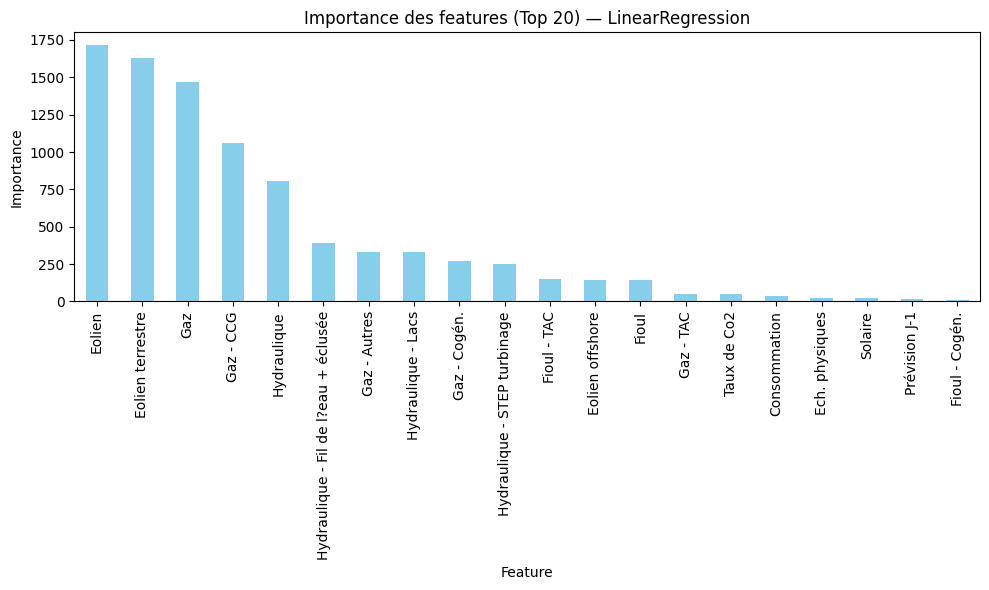

=== Ridge ===


Taux de Co2                             49.335919
Fioul - TAC                             19.596267
Gaz - CCG                               18.369979
Gaz - Autres                            14.021360
Nucléaire                               13.712300
Prévision J-1                           13.401214
Fioul                                   12.717381
Gaz - Cogén.                            11.815105
Hydraulique - Lacs                       9.978923
Ech. physiques                           9.807744
Hydraulique - Fil de l?eau + éclusée     9.556301
Charbon                                  8.684222
Gaz                                      7.142482
Ech. comm. Suisse                        5.060697
Fioul - Cogén.                           4.838935
Solaire                                  4.796782
Pompage                                  4.437506
Ech. comm. Espagne                       3.572271
Eolien terrestre                         3.376875
Hydraulique - STEP turbinage             2.701973


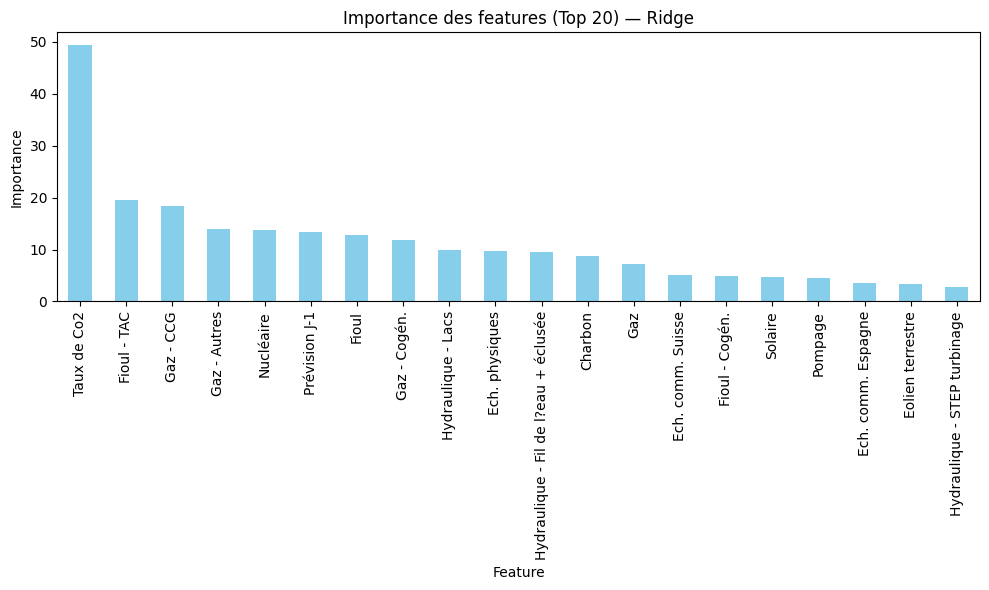

=== Lasso ===


Taux de Co2                             50.116477
Fioul - TAC                             38.666510
Fioul                                   31.796116
Gaz - CCG                               30.512376
Gaz - Autres                            17.975363
Ech. physiques                          15.170217
Gaz - Cogén.                            14.607251
Consommation                            13.806089
Hydraulique - Lacs                      13.603615
Prévision J-1                           13.548458
Hydraulique                             11.719591
Solaire                                 10.466727
Charbon                                  9.046598
Eolien                                   8.928978
Gaz                                      6.520875
Nucléaire                                6.297924
Fioul - Cogén.                           6.084392
Hydraulique - Fil de l?eau + éclusée     5.464920
Hydraulique - STEP turbinage             5.430268
Ech. comm. Suisse                        5.055140


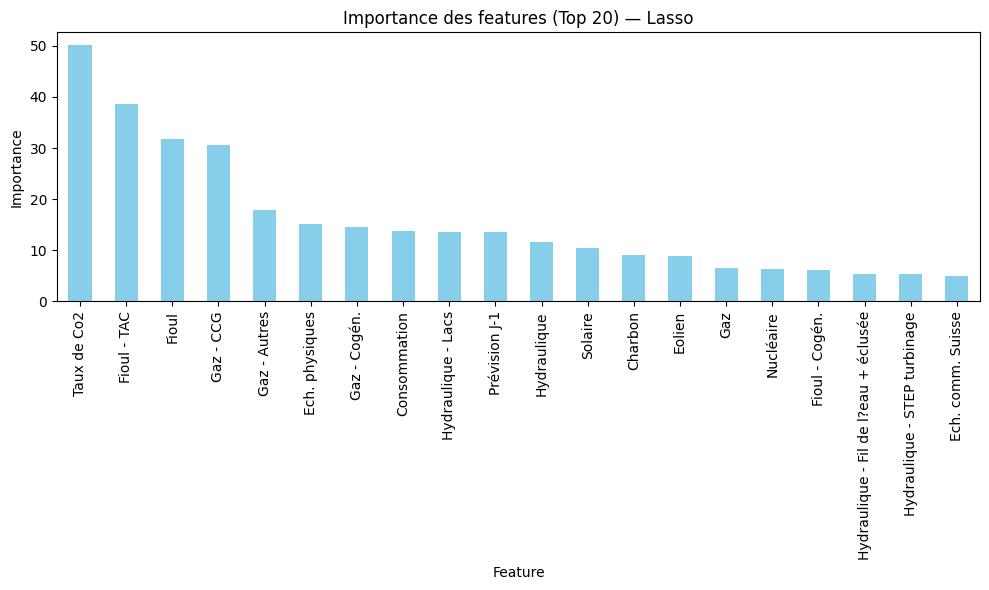

=== RandomForest ===


Nucléaire                               0.349104
Gaz - CCG                               0.281464
Pompage                                 0.072886
Hydraulique - Lacs                      0.032199
Fioul - Cogén.                          0.024142
Gaz - Autres                            0.020842
Gaz                                     0.020070
Ech. comm. Suisse                       0.014518
Charbon                                 0.014469
Gaz - Cogén.                            0.012797
Fioul - TAC                             0.012053
Hydraulique - Fil de l?eau + éclusée    0.011437
Hydraulique - STEP turbinage            0.011309
Ech. comm. Angleterre                   0.009326
Gaz - TAC                               0.008400
Hydraulique                             0.008046
Bioénergies - Biomasse                  0.008045
Ech. physiques                          0.007889
Taux de Co2                             0.007692
Ech. comm. Allemagne-Belgique           0.007537
dtype: float64

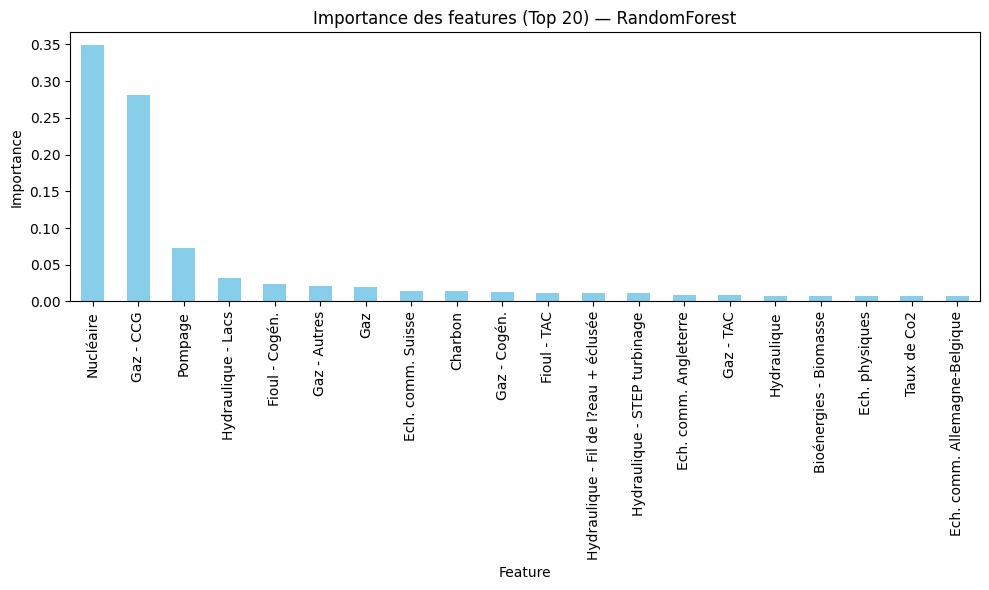

=== XGBRegressor ===


Gaz - CCG                               0.274847
Nucléaire                               0.240157
Pompage                                 0.076613
Hydraulique - Lacs                      0.042662
Fioul - TAC                             0.041571
Gaz - Autres                            0.032127
Gaz - TAC                               0.024473
Fioul - Cogén.                          0.023590
Ech. comm. Suisse                       0.022347
Gaz - Cogén.                            0.019806
Gaz                                     0.016600
Hydraulique - STEP turbinage            0.016520
Hydraulique - Fil de l?eau + éclusée    0.016355
Taux de Co2                             0.015957
Ech. comm. Angleterre                   0.013503
Solaire                                 0.012932
Charbon                                 0.011426
Eolien terrestre                        0.010110
Bioénergies - Biomasse                  0.009379
Hydraulique                             0.008116
dtype: float32

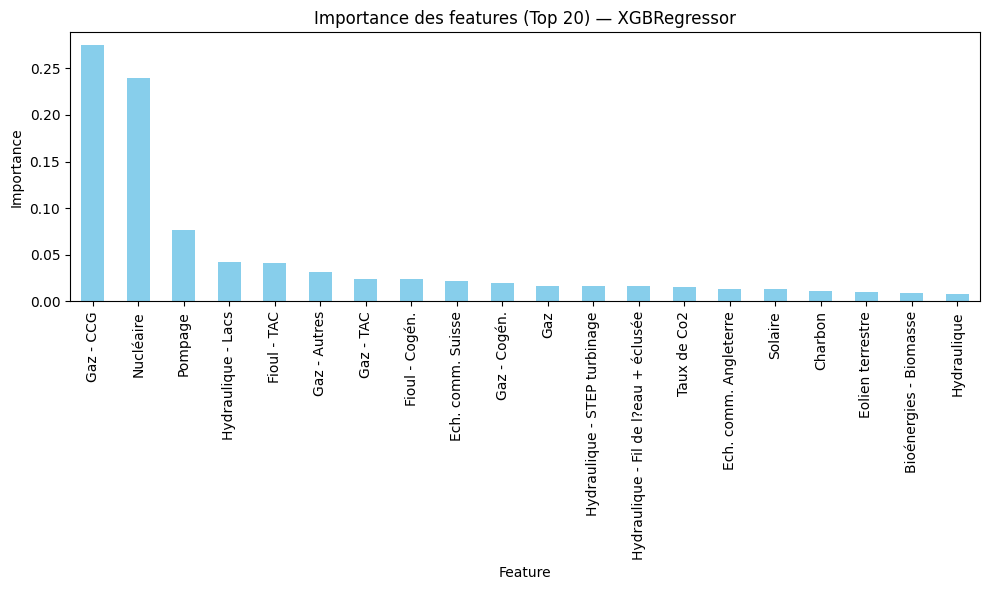

In [401]:
def plot_feature_importances(pipe, model_name, top_k=20):
    """
    Affiche les features d'importance pour un modèle donné.
    """
    try:
        mdl = pipe.named_steps["model"]
        if hasattr(mdl, "feature_importances_"):
            # Pour les modèles comme RandomForest, XGBoost
            fi = pd.Series(mdl.feature_importances_, index=FEATURE_LIST).sort_values(ascending=False)
        elif hasattr(mdl, "coef_"):
            # Pour les modèles linéaires comme Ridge, Lasso
            fi = pd.Series(np.abs(mdl.coef_), index=FEATURE_LIST).sort_values(ascending=False)
        else:
            print(f"({model_name}) pas de feature_importances_ ou coef_ disponibles.")
            return
        
        # Affichage des top_k features
        display(fi.head(top_k))
        plt.figure(figsize=(10, 6))
        fi.head(top_k).plot(kind="bar", color="skyblue")
        plt.title(f"Importance des features (Top {top_k}) — {model_name}")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erreur lors de l'affichage des importances pour {model_name}:", e)

# Afficher les features d'importance pour tous les modèles sauvegardés
for model_name, pipe in final_pipes.items():
    print(f"=== {model_name} ===")
    plot_feature_importances(pipe, model_name, top_k=20)

| Modèle                     | Idées d’amélioration                                                                                                                                                                                                                                                                                                                                                                                                |
| :------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **LinearRegression**       | - Ajouter des **interactions** entre variables (ex. Consommation × Saison, Eolien × Vent).<br>- Tester des modèles **Ridge / Lasso / ElasticNet** pour mieux gérer la multicolinéarité.<br>- Vérifier la **corrélation entre variables** et supprimer les colonnes redondantes.<br>- Ajouter des **features temporelles** (jour de la semaine, heure, mois, saison).                                                |
| **Ridge**                  | - Explorer plusieurs valeurs d’**alpha** (régularisation) via une recherche logarithmique.<br>- Tester **ElasticNet** pour combiner les pénalités L1 + L2.<br>- Vérifier que la **standardisation** est bien appliquée (déjà dans le pipeline).                                                                                                                                                                     |
| **Lasso**                  | - Balayer le paramètre **alpha** pour éviter la sur-pénalisation.<br>- Exploiter la **sparsité** pour la sélection automatique de variables.<br>- Comparer avec **ElasticNet** pour plus de flexibilité.<br>- Visualiser les **coefficients non nuls** pour interpréter les variables clés.                                                                                                                         |
| **RandomForest**           | - Optimiser les hyperparamètres : `n_estimators`, `max_depth`, `max_features`, `min_samples_leaf`.<br>- Tester des forêts plus légères (`max_samples` < 1.0) pour accélérer.<br>- Étudier les **importances de features** pour simplifier le modèle.<br>- Évaluer le **drift temporel** en refaisant la CV sur différentes années.                                                                                  |
| **XGBRegressor**           | - Régler finement `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`.<br>- Utiliser **early stopping** avec un split de validation temporelle.<br>- Ajouter des **lags** (t-1, t-24) et des moyennes glissantes pour capter la dynamique.<br>- Surveiller le **drift des données** et prévoir un ré-entraînement périodique.                                                                             |
| **Général / Tous modèles** | - Ajouter des **features calendaires** (jour, semaine, vacances, fériés, saison).<br>- Intégrer des **variables météo** (température, vent, irradiance).<br>- Faire une **recherche d’hyperparamètres** avec `TimeSeriesSplit`.<br>- Tester des modèles plus avancés : **Gradient Boosting, LightGBM, CatBoost, LSTM**.<br>- Mettre en place une **surveillance de performance** dans le temps (backtest glissant). |
